# 1. 데이터 불러오기

In [1]:
# 기초 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터의 파일 경로 설정 및 파일 이름 확인
import os

path = os.getcwd() + '/data'
data_files = os.listdir(path)
print('Data files: ', data_files)

Data files:  ['sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
train_origin = pd.read_csv(path+'/train.csv')  # train 데이터 불러오기
test_origin = pd.read_csv(path+'/test.csv')    # test 데이터 불러오기
train_origin.shape, test_origin.shape    # 데이터 정보 확인

((20000, 23), (10000, 22))

In [4]:
# 데이터 요약 정보 확인 함수 정의
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': 'Feature'})
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values

    return summary

# EDA를 통한 Insight 정리
1. 데이터에 결측치는 보이지 않는다. 별도의 결측치 처리는 필요 없을 것 같다.
2. Object 변수들이 대부분을 차지하고 있다. 각 변수의 특징에 맞춰 적절한 처리를 해주어야 할 것으로 보인다.
3. 수치형 자료들의 경우 Age를 제외한 Gains, Losses, Dividends는 사실상 유효한 값은 모두 이상치로 잡힌다.
   - 아무래도 0이 default 값이라 생각된다.
   - Age도 약간의 이상치가 관측은 된다.
   - 아무래도 Gains, Losses, Dividends는 극단적으로 값이 치우쳤기 때문에 차라리 있음/없음의 범주형 데이터로 변환하는 편이 낫지 않을까 하는 생각을 한다.
4. Income의 분포를 살펴보면 박스가 아래쪽으로 많이 치우쳐져 있다.
   - 이는 많은 이들의 소득이 0으로 잡히기 때문이라 생각된다.
   - 모델을 학습시킬 때 소득이 0인 경우를 제외하고 학습을 시킬 필요가 있어 보이며, 소득이 0인 경우와 아닌 경우를 나누어서 분석해볼 필요가 있을 것 같다.
5. 소득이 0인 집단에서 핵심이라 생각되는 feature를 살펴보면 다음과 같다.
   - Employment_Status에서 절반 이상이 'Children or Armed Forces'로 보인다.
   - Working_Week (Yearly)에서 절반 이상은 일을 하지 않는 것으로 나타났다.
     - 특히 전체 데이터에서 Not Working인 사람 1221명 모두 소득이 0인 게 확인되었다.
   - Industry_Status에서도 절반 이상은 Not in universe or children으로 관측된다.
   - Education_Status는 학력이 높아질때마다 Income도 높아지는 경향이 관측된다.
     - 특히 전체 데이터에서 Children인 사람 2208명 모두 소득이 0으로 집계된다.

# 2. Preprocessing

In [5]:
# 전처리 전 원본 데이터 복사
train = train_origin.copy()
test = test_origin.copy()

In [6]:
# 'Gains', 'Losses', 'Dividends'를 이진 변수로 변환(값이 있으면 1, 없으면 0)
train['Gains'] = train['Gains'].apply(lambda x: 1 if x > 0 else 0)
train['Losses'] = train['Losses'].apply(lambda x: 1 if x > 0 else 0)
train['Dividends'] = train['Dividends'].apply(lambda x: 1 if x > 0 else 0)

In [7]:
resumetable(train)

Data Shape: (20000, 23)


,Feature,dtypes,Missing,Uniques,First Value,Second Value
0,ID,object,0,20000,TRAIN_00000,TRAIN_00001
1,Age,int64,0,91,63,37
2,Gender,object,0,2,M,M
3,Education_Status,object,0,17,Middle (7-8),Associates degree (Vocational)
4,Employment_Status,object,0,8,Full-Time,Full-Time
5,Working_Week (Yearly),int64,0,53,4,52
6,Industry_Status,object,0,24,Social Services,Entertainment
7,Occupation_Status,object,0,15,Services,Services
8,Race,object,0,5,White,White
9,Hispanic_Origin,object,0,10,All other,All other


In [8]:
# Isolation Forest를 이용한 이상치 제거
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, contamination=0.01, random_state=42)     # 이상치 비율 1%로 설정
clf.fit(train[['Income']])
outlier = clf.predict(train[['Income']])
train['Income_outlier'] = outlier

In [9]:
train = train[train['Income_outlier'] == 1]    # 이상치 제거
train = train.drop(columns=['Income_outlier'])    # 이상치 제거 후 컬럼 삭제

In [10]:
train.shape, test.shape

((19810, 23), (10000, 22))

# 3. Feature Engineering

### (1) 각 feature 적당히 처리

In [11]:
train.shape, test.shape

((19810, 23), (10000, 22))

In [12]:
# Feature Engineering1
all_data = pd.concat([train, test], axis=0)    # train과 test 데이터 병합
all_data.drop('ID', axis=1, inplace=True)     # ID는 인코딩할 필요 없으므로 제외
all_data.shape

# Feature Engineering2 (아무래도 안 없애는 게 성능이 더 좋아보이는 듯 함)
#all_data = pd.concat([train, test], axis=0)    # train과 test 데이터 병합
#all_data.drop(['ID', 'Gains', 'Dividends', 'Household_Status'], axis=1, inplace=True)
#all_data.shape

(29810, 22)

In [13]:
all_data.shape

(29810, 22)

In [14]:
# 명목형과 수치형 자료 분류1
category = ['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Status', 'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status', 'Income_Status']
numeric = ['Age', 'Working_Week (Yearly)', 'Gains', 'Losses', 'Dividends']

# 명목형과 수치형 자료 분류2
#category = ['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status', 'Income_Status']
#numeric = ['Age', 'Working_Week (Yearly)', 'Losses']

In [15]:
# 수치형 변수 StandardScaler 적용
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_data[numeric] = scaler.fit_transform(all_data[numeric])


# 범주형 변수 인코딩(OHE)
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder()
encoded_data = OHE.fit_transform(all_data[category]).toarray()    # OneHotEncoder를 사용하여 범주형 변수 인코딩
encoded_data = pd.DataFrame(encoded_data, columns=OHE.get_feature_names_out(category))    # 인코딩된 데이터를 DataFrame으로 변환

In [16]:
# 다시 train, test 데이터 분할
train = all_data[:len(train)].reset_index(drop=True)
test = all_data[len(train):].reset_index(drop=True)

train_encoded = encoded_data[:len(train)].reset_index(drop=True)
test_encoded = encoded_data[len(train):].reset_index(drop=True)

In [17]:
# 기존의 범주형 변수 제거 후 인코딩된 범주형 변수 추가
train = train.drop(category, axis=1)
train = pd.concat([train, train_encoded], axis=1)

test = test.drop(category, axis=1)
test = pd.concat([test, test_encoded], axis=1)

In [18]:
train.shape, test.shape

((19810, 277), (10000, 277))

### (3) Data Downcasting
> 메모리를 효율적으로 사용하기 위해 다운캐스팅

> 이번 데이터는 양호하지만, 판다스에서는 데이터를 불러오면 기본적으로 정수는 int64, 실수는 float64타입으로 할당하기 때문에 데이터가 큰 경우 downcasting을 하는 편이 메모리 낭비도 막고 훈련 속도도 빨라진다.
> - object 타입은 그대로 두고, Bool 타입은 int8, 정수형 타입은 해당 데이터에 맞는 가장 작은 타입으로 변환한다.
> - 실수형 타입은 소수점 첫째 자리에서 반올림한 수가 원래 수와 같다면 정수형 타입 중 해당 데이터에 맞는 가장 작은 타입으로 바꾼다.
> - 그 외의 실수형은 해당 데이터에 맞는 가장 작은 타입으로 바꾼다.

In [19]:
# downcast 함수 정의
def downcast(df, verbose=True):     # verbose 옵션 추가: (True)인 경우 몇 퍼센트 압축됐는지 출력
    start_mem = df.memory_usage().sum() / 1024**2   # 초기 메모리 사용량
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'{(100*(start_mem - end_mem) / start_mem):.1f}% 압축됨')

    return df

In [20]:
# 메모리 사용량 최적화
train = downcast(train)
test = downcast(test)

86.8% 압축됨
86.7% 압축됨


# 시험 모델링

In [20]:
# train, validation 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train.drop('Income', axis=1), train['Income'], test_size=0.2, random_state=42)

In [21]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((15848, 242), (3962, 242), (15848,), (3962,))

In [22]:
# 성능지표 정의: RMSE
from sklearn.metrics import mean_squared_error

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## 모델링1 - 냅다 돌려보기

In [ ]:
# 후보1: Random Forest Regressor 모델 생성
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

Train RMSE:  241.2263707826008


In [ ]:
# train 데이터에 대한 예측
y_train_pred = rf.predict(X_train)
print('Train RMSE: ', rmse(y_train, y_train_pred))

# 검증 데이터에 대한 예측
y_val_pred = rf.predict(X_val)
print('Validation RMSE: ', rmse(y_val, y_val_pred))

Validation RMSE:  624.8324205286194


## 모델링2 - 냅다 돌려보기2

In [24]:
# 후보2: LightGBM 모델
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(n_estimators=300, max_depth=10, metric = 'rmse', num_leaves = 255, learning_rate = 0.01,
                    force_col_wise = True, random_state = 42, objective='regression')
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 215
[LightGBM] [Info] Start training from score 520.061522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMRegressor(force_col_wise=True, learning_rate=0.01, max_depth=10,
              metric='rmse', n_estimators=300, num_leaves=255,
              objective='regression', random_state=42)

In [25]:
# 성능 평가

# 훈련 데이터에 대한 예측값
train_pred = lgbm.predict(X_train)
train_rmse = RMSE(y_train, train_pred)
print(f'RMSE: {train_rmse:.4f}')

val_pred = lgbm.predict(X_val)
val_rmse = RMSE(y_val, val_pred)
print(f'RMSE: {val_rmse:.4f}')

RMSE: 415.4335
RMSE: 453.6204


## 모델링3 - 나만의 모델

In [47]:
# 후보 번외) 나만의 모델 만들기
# 기본적으로 학습된 lgm 모델을 사용하지만, predict 단계에서 X_train['Education_Status_Children'] == 1일 경우 0, X_train['Employment_Status_Not Working'] == 1일 경우 0을 반환하는 모델
from sklearn.base import BaseEstimator, TransformerMixin

class MyModel(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        y_pred = self.model.predict(X)
        y_pred[(X['Education_Status_Children'] == 1) | (X['Employment_Status_Not Working'] == 1)] = 0
        return y_pred

my_model = MyModel(lgb_model)


In [49]:
# 성능 평가
from sklearn.metrics import mean_squared_error

y_pred = my_model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f'RMSE: {rmse:.4f}')

y_pred = my_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 361.1067
RMSE: 497.1241


## 모델링4 - EDA 및 전처리 추가

In [71]:
# LightGBM 모델
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val)

params = {
    'num_iterations': 300,      # 반복 수행하려는 트리의 개수 (너무 크면 오버피팅 발생)
    'max_depth': 10,            #* 트리의 최대 깊이 (너무 크면 오버피팅 발생)   # 보통 3~12(가장 민감하므로 먼저 튜닝해야할 값) # lightgbm처럼 leaf-wise로 학습하는 경우 끝까지(-1)도 괜찮다고 한다.
    # 'boosting_type' = 'gbdt'  # 부스팅 타입 (gbdt: Gradient Boosting Decision Tree, rf: RandomForest)
    # 'min_data_in_leaf' = 30   #* 한 리프의 최소 데이터 수 (클수록 오버피팅 방지, 너무 크면 과소적합)
    'objective': 'regression',  #* 수치예측이면 regression, 이진분류이면 binary, 다중분류이면 multiclass
    'metric': 'rmse',           # 성능지표 (rmse: Root Mean Squared Error)
    'num_leaves': 255,          #* 하나의 트리가 가질 수 있는 최대 리프 수 (2번째로 민감. max_depth와 함께 튜닝)
    'learning_rate': 0.01,      # 부스팅 스탭 반복할 때 학습률(0~1) #튜닝시 0.1~0.3, 최종 모형은 0.05 이하
    'force_col_wise': True,     # 데이터가 많을 때 속도 향상
    'random_state': 42
}

lgb_model = lgb.train(params=params,
                    train_set = lgb_train,
                    num_boost_round=500,
                    valid_sets=[lgb_train, lgb_val])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 215
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 520.061522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [72]:
# 성능 평가
from sklearn.metrics import mean_squared_error

# 훈련 데이터에 대한 예측값
y_pred = lgb_model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f'RMSE: {rmse:.4f}')

y_pred = lgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 415.4335
RMSE: 453.6204


## 모델링5 - EDA 및 전처리 추가

> - 아무래도 Income의 분포 자체가 많이 치우쳐져 있다 보니 log scale로 변환하여 예측해보자.
> - 수치형 자료들과 Income의 상관관계를 보았을 때 ['Gains', 'Dividends']는 거의 0에 가깝게 나온다. 아예 없애는 편이 나을지도 모르겠다.
> - Household_Status도 Household_Summary라는 요약 정보가 있으니 제거하는 편이 어떨까 싶다.

In [25]:
train.shape, test.shape

((19810, 243), (10000, 243))

In [26]:
# train, validation 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train.drop('Income', axis=1), train['Income'], test_size=0.2, random_state=42)

In [27]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((15848, 242), (3962, 242), (15848,), (3962,))

In [28]:
# 성능지표 정의: RMSE
from sklearn.metrics import mean_squared_error

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#### (1) 로그 변환

In [23]:
# 타깃 변수 로그 변환
y_train_log = np.log1p(y_train)

In [24]:
y_train_log

18938    0.000000
17462    6.216606
14152    0.000000
7346     0.000000
3048     6.502790
           ...   
11284    0.000000
11964    0.000000
5390     6.752270
860      6.781058
15795    5.993961
Name: Income, Length: 15848, dtype: float32

In [25]:
# 모델 훈련(LightGBM)
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(n_estimators=500, max_depth=10, metric = 'rmse', num_leaves = 255, learning_rate = 0.01,
                    force_col_wise = True, random_state = 42, objective='regression')
lgbm.fit(X_train, y_train_log)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 192
[LightGBM] [Info] Start training from score 3.776246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMRegressor(force_col_wise=True, learning_rate=0.01, max_depth=10,
              metric='rmse', n_estimators=500, num_leaves=255,
              objective='regression', random_state=42)

In [26]:
# 성능 평가

# 훈련 데이터에 대한 예측값
train_pred = lgbm.predict(X_train)
train_pred = np.expm1(train_pred)    # 로그 변환 전으로 변환
train_rmse = RMSE(y_train, train_pred)
print(f'RMSE: {train_rmse:.4f}')

val_pred = lgbm.predict(X_val)
val_pred = np.expm1(val_pred)    # 로그 변환 전으로 변환
val_rmse = RMSE(y_val, val_pred)
print(f'RMSE: {val_rmse:.4f}')

RMSE: 621.8039
RMSE: 645.5948


#### (2) 로그 변환 X

In [31]:
# 모델 훈련(LightGBM)
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(n_estimators=500, max_depth=10, metric = 'rmse', num_leaves = 255, learning_rate = 0.01,
                    force_col_wise = True, random_state = 42, objective='regression')
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 192
[LightGBM] [Info] Start training from score 520.061522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMRegressor(force_col_wise=True, learning_rate=0.01, max_depth=10,
              metric='rmse', n_estimators=500, num_leaves=255,
              objective='regression', random_state=42)

In [32]:
# 성능 평가

# 훈련 데이터에 대한 예측값
train_pred = lgbm.predict(X_train)
train_rmse = RMSE(y_train, train_pred)
print(f'RMSE: {train_rmse:.4f}')

val_pred = lgbm.predict(X_val)
val_rmse = RMSE(y_val, val_pred)
print(f'RMSE: {val_rmse:.4f}')

RMSE: 400.3246
RMSE: 449.8773


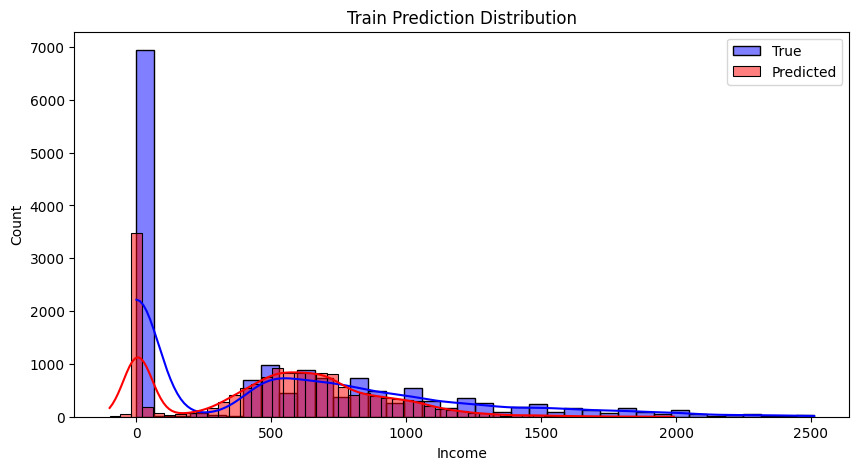

In [33]:
# train 예측에 대한 분포
plt.figure(figsize=(10, 5))
sns.histplot(y_train, kde=True, color='blue', label='True')
sns.histplot(train_pred, kde=True, color='red', label='Predicted')
plt.legend()
plt.title('Train Prediction Distribution')
plt.show()

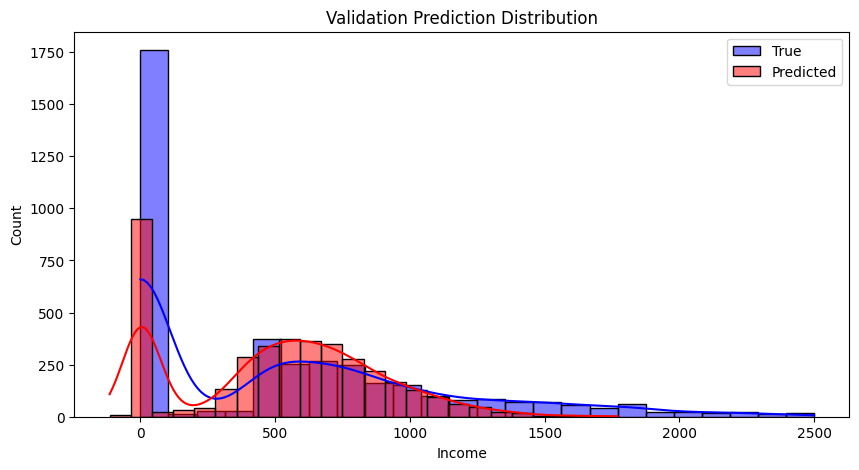

In [30]:
# validation 예측에 대한 분포
plt.figure(figsize=(10, 5))
sns.histplot(y_val, kde=True, color='blue', label='True')
sns.histplot(val_pred, kde=True, color='red', label='Predicted')
plt.legend()
plt.title('Validation Prediction Distribution')
plt.show()

In [34]:
# 하이퍼파라미터 튜닝 test
bayesian_params = {
    'max_depth':(6, 16), #트리 최대 깊이
    'num_leaves':(24,255), #트리 하나에 최대 잎 개수
    'min_child_samples': (10, 200), #하나의 잎에 최소 데이터 개수 (오버피팅 대응)
    'min_child_weight': (1, 50), #하나의 잎에 최소 sum hessian
    'subsample': (0.5, 1), #
    'colsample_bytree': (0.5, 1), #피처의 50% 를 트레이닝 전에 선택
    'max_bin': (10, 500), #bins 의 최대 개수
    'reg_lambda': (0.001, 10), #L2 regularization
    'reg_alpha': (0.01, 50) #L1 regularization 
}

In [37]:
def lgb_roc_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha):
    params = {
    "n_estimators" : 500, "learning_rate": 0.01,
    'max_depth': int(round(max_depth)),
    'num_leaves': int(round(num_leaves)),
    'min_child_samples': int(round(min_child_samples)),
    'min_child_weight': int(round(min_child_weight)),
    'subsample': max(min(subsample, 1), 0), # 0 과 1 사이
    'colsample_bytree': max(min(colsample_bytree, 1), 0),
    'max_bin':  max(int(round(max_bin)),10),
    'reg_lambda': max(reg_lambda,0),
    'reg_alpha': max(reg_alpha, 0)
    }

    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric= 'rmse')
    valid_proba = lgb_model.predict(X_val)
    rmse = RMSE(y_val, valid_proba)

    return rmse

In [38]:
from bayes_opt import BayesianOptimization

lgbBO = BayesianOptimization(f= lgb_roc_eval, pbounds=bayesian_params, random_state = 42)
lgbBO.maximize(init_points = 5, n_iter = 25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 106
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 520.061522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [39]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

[451.4530645199407, 452.31699795019966, 448.9062671196467, 456.7689112606915, 449.130938628618, 456.64772486059354, 453.2496512414664, 453.68696907765974, 456.7774940711628, 452.47801161379505, 453.1489913678699, 452.422322741927, 452.31454000009455, 456.2625548380392, 452.32187138225754, 448.30332876459767, 452.6825922397247, 451.49226135976375, 452.4905116474052, 452.16657794510303, 452.554730365278, 453.3888246382883, 453.47174622733854, 452.86051252835347, 451.71214570399917, 452.5308617396361, 454.7105024224901, 451.3772961468086, 453.4150385390175, 451.3083274610478]
maximum target index: 8
{'target': 456.7774940711628, 'params': {'colsample_bytree': 1.0, 'max_bin': 324.3388766118788, 'max_depth': 6.0, 'min_child_samples': 144.3019249032423, 'min_child_weight': 1.0, 'num_leaves': 125.70848399277916, 'reg_alpha': 50.0, 'reg_lambda': 10.0, 'subsample': 1.0}}


In [41]:
params = {
    "n_estimators" : 500,
    "learning_rate": 0.01,
    'colsample_bytree': 1.0,
    'max_bin': 324,
    'max_depth': 6,
    'min_child_samples': 144,
    'min_child_weight': 1.0,
    'num_leaves': 125,
    'reg_alpha': 50.0,
    'reg_lambda': 10.0,
    'subsample': 1.0
    }

In [42]:
lgbm = LGBMRegressor(**params)
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 101
[LightGBM] [Info] Start training from score 520.061522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor(learning_rate=0.01, max_bin=324, max_depth=6,
              min_child_samples=144, min_child_weight=1.0, n_estimators=500,
              num_leaves=125, reg_alpha=50.0, reg_lambda=10.0)

In [43]:
# 성능 평가

# 훈련 데이터에 대한 예측값
train_pred = lgbm.predict(X_train)
train_rmse = RMSE(y_train, train_pred)
print(f'RMSE: {train_rmse:.4f}')

val_pred = lgbm.predict(X_val)
val_rmse = RMSE(y_val, val_pred)
print(f'RMSE: {val_rmse:.4f}')

RMSE: 440.4688
RMSE: 456.7775


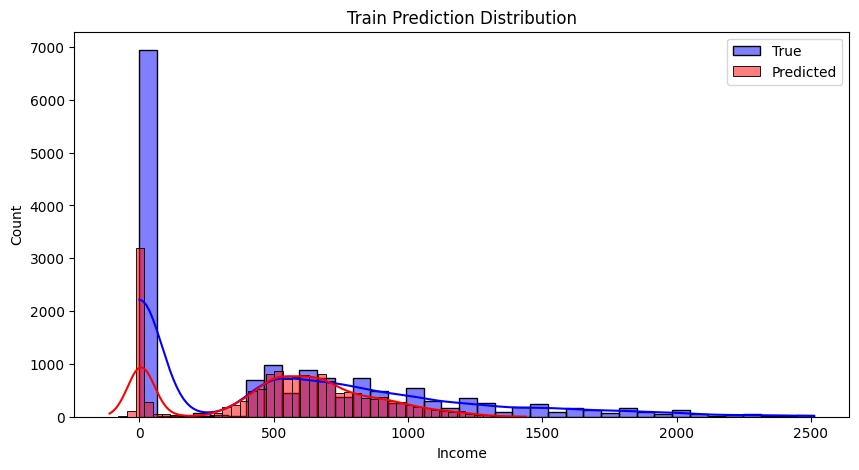

In [44]:
# train 예측에 대한 분포
plt.figure(figsize=(10, 5))
sns.histplot(y_train, kde=True, color='blue', label='True')
sns.histplot(train_pred, kde=True, color='red', label='Predicted')
plt.legend()
plt.title('Train Prediction Distribution')
plt.show()

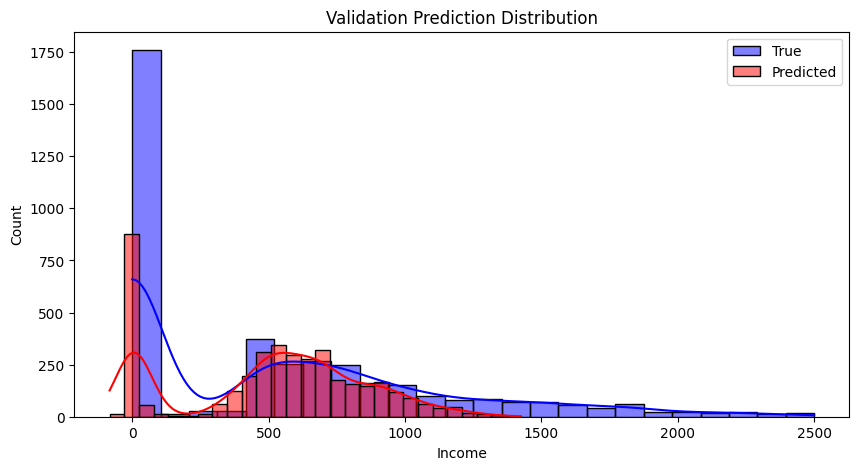

In [45]:
# validation 예측에 대한 분포
plt.figure(figsize=(10, 5))
sns.histplot(y_val, kde=True, color='blue', label='True')
sns.histplot(val_pred, kde=True, color='red', label='Predicted')
plt.legend()
plt.title('Validation Prediction Distribution')
plt.show()

## 제출할 때

In [46]:
# 제출용 데이터 확인
submission = pd.read_csv(path+'/sample_submission.csv')
submission.head()

,ID,Income
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [47]:
# test 데이터에 대한 예측값
test.drop('Income', axis=1, inplace=True)

test_pred = lgbm.predict(test)
test_pred

array([  4.11285968,   2.8570459 , 387.2726055 , ..., 320.53645599,
         7.2233992 , 642.74941993])

In [49]:
# 제출용 파일 생성
submission['Income'] = test_pred
submission.to_csv('submission7.csv', index=False)